# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time, datetime
import citipy
from citipy import citipy
import os
import sys
import os.path
from scipy.stats import linregress
import json
from tqdm import tqdm

orig_wd = os.getcwd()
os.chdir(os.path.join('..','..','..','..','..'))
from config import weather_api_key
os.chdir(orig_wd)
debug = True

# Output File (CSV)
output_data_file = ".\cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [2]:
from pygments import highlight, lexers, formatters
def ppj (json_obj, dbug=False):
    colormej = json.dumps(json_obj, sort_keys=True, indent=4)
    colorful_json = highlight(colormej, lexers.JsonLexer(), formatters.TerminalFormatter())
    if dbug: print(colorful_json)

def weather_outside(where_list, dbug=False):
    # recieve list of cities, return dict of city weather
    # checks for valid weather for each city, only returns the sucessful
    url = "http://api.openweathermap.org/data/2.5/weather?"
    units = "imperial"
    city_dict = {}
    
    # add a progress bar to the function
    pbar_cities = tqdm(where_list)

    for i, city in enumerate(pbar_cities):
        query_string = f"{url}appid={weather_api_key}&units={units}&q={city}"
        returned = requests.get(query_string).json()
        if dbug: print(f"checking weather for {city}\n{'--'*30}\n{ppj(returned, dbug)}")
        if 'sys' in returned:
            if dbug: print(f"\t Status avaialble, {returned['weather'][0]['main']}\n")
            city_dict[city] = {
                "City": returned['name'],
                'Date' : returned['dt'],
                'Country' : returned['sys']['country'],
                'Humidity' : returned['main']['humidity'],
                'Max Temperature' : returned['main']['temp_max'],
                'Wind Speed' : returned['wind']['speed'],
                'Conditions' : returned['weather'][0]['main'],
                'Cond_description' : returned['weather'][0]['description'],
                'Latitude' : returned["coord"]["lat"],
                'Longitude' : returned["coord"]["lon"],
                'Cloudiness' : returned["clouds"]["all"]
                }
        pbar_cities.set_description(f"Processing ({i+1}) [{city}]{' '*(20-len(city))}")
    return city_dict

def plot_weather (datafr, x, y, clr='blue', title=['City','(mph)']):
    cust_plot = plt.scatter(datafr[x], datafr[y], facecolors=clr, marker="o", edgecolor="black")
    plt.title(f"{title[0]} {x} vs. {y} ({datetime.date.fromtimestamp(datafr['Date'].max())})")
    plt.ylabel(f"{y} {title[1]}")
    plt.xlabel(f"{x}")
    plt.grid(True)
    return cust_plot

# if I wasn't behind already I'd combine these into one function, since they are so similar....

def plot_reg (datafr, x, y, clr='blue', title=['Heading','(type)']):
    cust_plot = plt.scatter(datafr[x], datafr[y], facecolors=clr, marker="o", edgecolor="black")
    x_vals = datafr[x]
    y_vals = datafr[y]
    (slope, intercept, rval, pval, stderr) = linregress(x_vals, y_vals)
    reg_vals = x_vals * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_vals,y_vals)
    plt.plot(x_vals,reg_vals,"r-")
    #if slope
    annx = min(x_vals)# -10
    anny = min(y_vals) + title[2]# 60
    
    #annx = abs(intercept - max(x_vals) - 2)# -10
    #anny = slope - max(y_vals)- 2 # 60
    
    plt.annotate(line_eq,(annx,anny),fontsize=15,color="red")
    plt.title(f"{title[0]} - {x} vs. {y} Linear Regression")
    plt.ylabel(f"{y} {title[1]}")
    plt.xlabel(f"{x}")
    plt.grid(True)
    return cust_plot

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
city_dict = {}

# Create a set of random lat and lng combinations
lat_lngs = zip(np.random.uniform(lat_range[0], lat_range[1], size=1500),\
               np.random.uniform(lng_range[0], lng_range[1], size=1500))

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

return_weather = weather_outside(cities, False)
#return_weather

Processing (629) [changji]             : 100%|███████████████████████████████████████| 629/629 [00:43<00:00, 14.52it/s]


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
print(f" From [{len(cities)}] cities checked, only [{len(return_weather)}] cites returned valid weather data via the API, or {round(len(return_weather)/len(cities),4)*100}%")

 From [629] cities checked, only [584] cites returned valid weather data via the API, or 92.85%


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# Create a DataFrame 
weather_df = pd.DataFrame([return_weather[k] for k in return_weather.keys()])
# Display DataFrame
weather_df.head(2)

,City,Date,Country,Humidity,Max Temperature,Wind Speed,Conditions,Cond_description,Latitude,Longitude,Cloudiness
0,Pitimbu,1590972380,BR,100,75.20,3.36,Clouds,overcast clouds,-7.47,-34.81,100
1,Qaanaaq,1590972380,GL,92,25.36,1.59,Clear,clear sky,77.48,-69.36,5


In [6]:
print(os.getcwd())
# Export to a CSV
weather_df.to_csv(output_data_file)

C:\Users\SeaLord\class\TK-GW-HW\week_6_api_dev\API_challenge\case_assignments\weather


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
#remove any cities with over 100% huimidity
cities_under_100 = weather_df[weather_df["Humidity"] < 100]
print(f'The initial max humidity is {weather_df["Humidity"].max()}% in data from {len(weather_df)} cites\n{"--"*30}\nAfter filtering, the max is {cities_under_100["Humidity"].max()}%, in data from {len(cities_under_100)} cites\n')

The initial max humidity is 100% in data from 584 cites
------------------------------------------------------------
After filtering, the max is 99%, in data from 573 cites



## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

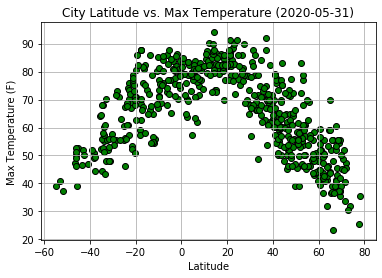

In [8]:
w_plot = plot_weather(cities_under_100, "Latitude", "Max Temperature", "green", ["City","(F)"])
plt.savefig("Max_Temperature.png")
w_plot

Latitude vs. Temperature Plot: with no surprise, shows that as you move closer to the poles the Max Temperature drops closer to freezing or below, also that there are fewer cities in the Southern most Latitudes as compared to the Northern Hem

## Latitude vs. Humidity Plot

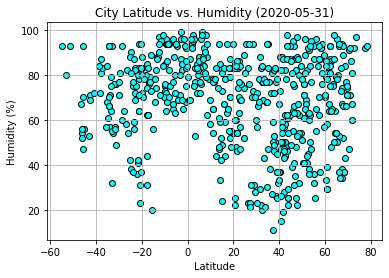

In [9]:
w_plot = plot_weather(cities_under_100, "Latitude", "Humidity", "aqua", ["City","(%)"])
plt.savefig("Humidity.png")
w_plot

Latitude vs. Humidity Plot: This plot seems to indicate that there are fewer cities in the Southern Hem with low Humitity, this must be due to the time of year this sample was taken, as opposed to the annual average which is probably more recognizable towards normal.

## Latitude vs. Cloudiness Plot

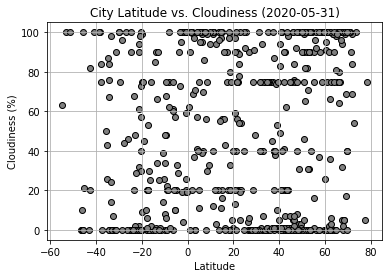

In [10]:
w_plot = plot_weather(cities_under_100, "Latitude", "Cloudiness", "grey", ["City","(%)"])
plt.savefig("Cloudiness.png")
w_plot

Latitude vs. Cloudiness Plot: This seems to indicate common percentages an multiple latitudes, which shows trends at 0%, 20%, 75% and 100% cloud cover... 

## Latitude vs. Wind Speed Plot

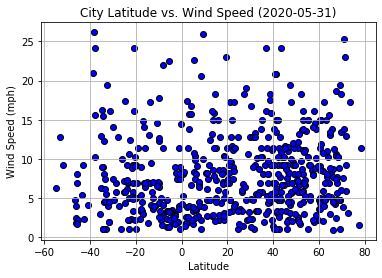

In [11]:
w_plot = plot_weather(cities_under_100, "Latitude", "Wind Speed", "blue", ["City","(mph)"])
plt.savefig("Wind_Speed.png")
w_plot

Latitude vs. Wind Speed Plot: This plot would indicate low speed wind in most cities. 

## Linear Regression

In [12]:
northern_df= cities_under_100[cities_under_100["Latitude"] >= 0]
southern_df= cities_under_100[cities_under_100["Latitude"] < 0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

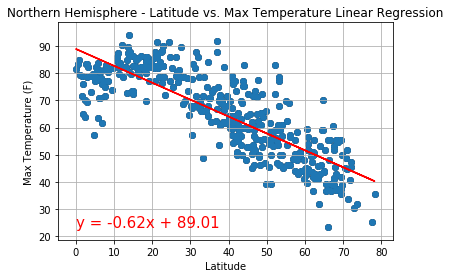

In [13]:
w_plot = plot_reg(northern_df, "Latitude", "Max Temperature", "blue", ["Northern Hemisphere","(F)",0])
plt.savefig("NH_Max_Temperature.png")
w_plot

Northern Hemisphere - Max Temp vs. Latitude Linear Regression: as before, the upper latitudes trend towards a lower temperature

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

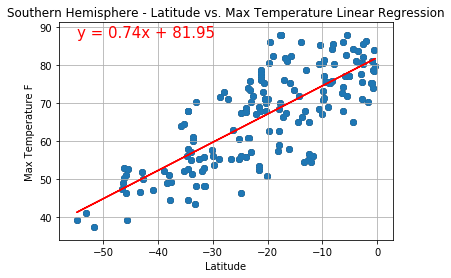

In [14]:
w_plot = plot_reg(southern_df, "Latitude", "Max Temperature", "blue",["Southern Hemisphere","F",50])
plt.savefig("SH_Max_Temperature.png")
w_plot

Southern Hemisphere - Max Temp vs. Latitude Linear Regression: in the Southern Hemisphere, the closer you get to the Tropics and Equator, the Temperature trends higher

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

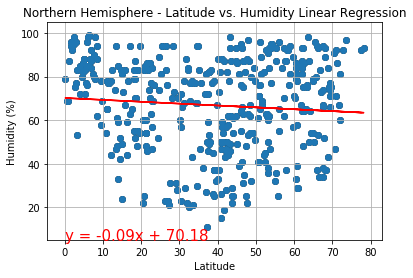

In [15]:
w_plot = plot_reg(northern_df, "Latitude", "Humidity", "aqua",["Northern Hemisphere","(%)",-6])
plt.savefig("NH_Humidity.png")
w_plot

Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression: Today seems to be fairly humid (60%-95%) in most cities at all latitudes. 

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

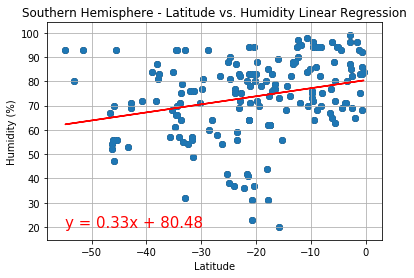

In [16]:
w_plot = plot_reg(southern_df, "Latitude", "Humidity", "blue",["Southern Hemisphere","(%)",0])
plt.savefig("SH_Humidity.png")
w_plot

Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression: Humidity is slightly higher in Southern cities closer to the Equator, no real suprise there. 

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

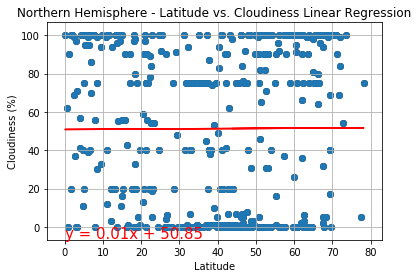

In [17]:
w_plot = plot_reg(northern_df, "Latitude", "Cloudiness", "grey",["Northern Hemisphere","(%)",-6])
plt.savefig("NH_Cloudiness.png")
w_plot

there is a mix of 0% to 100% at all latitudes, trending towards more clouds in the higher latitudes

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

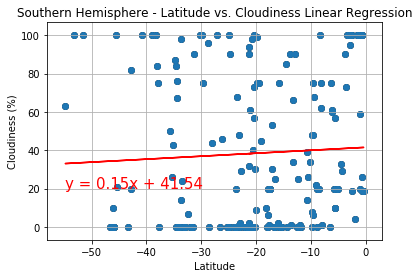

In [18]:
w_plot = plot_reg(southern_df, "Latitude", "Cloudiness", "grey",["Southern Hemisphere","(%)",20])
plt.savefig("SH_Cloudiness.png")
w_plot

Similar to the Northern Hemisphere, there is a mix of readings, but trending to more clouds in the north than south.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

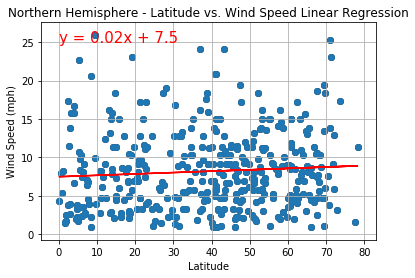

In [19]:
w_plot = plot_reg(northern_df, "Latitude", "Wind Speed", "grey",["Northern Hemisphere","(mph)",24])
plt.savefig("NH_Wind_Speed.png")
w_plot

It would seem its a good day to fly a kite wherever you may live, except for those three cities with 1 mph wind, maybe a gust here or there will help them.

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

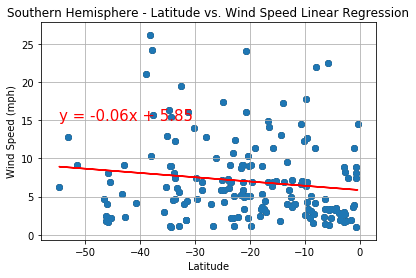

In [20]:
w_plot = plot_reg(southern_df, "Latitude", "Wind Speed", "grey",["Southern Hemisphere","(mph)",14])
plt.savefig("SH_Wind_Speed.png")
w_plot

The Southern Hemisphere has a mix of wind speeds, most are in the single digits, particularly nearer to the Equator.